In [1]:
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --only-binary :all: 
!pip install -q transformers==4.38.2 accelerate==0.28.0 pandas scikit-learn wandb unidecode nltk seaborn tqdm emoji huggingface_hub matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import re
import random
import emoji
import nltk
import torch
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm # Use tqdm.notebook for better notebook integration
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from nltk.tokenize import word_tokenize
from huggingface_hub import login
import joblib # For saving SVM model
from kaggle_secrets import UserSecretsClient

In [3]:
try:
    user_secrets = UserSecretsClient()
    HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
    # WANDB_API_KEY = user_secrets.get_secret("WANDB_API_KEY") # Keep commented if not used
    print("Kaggle secrets loaded successfully.")
except Exception as e:
    print(f"Warning: Could not load Kaggle secrets. Using placeholder token. Error: {e}")
    HF_TOKEN = "YOUR_HF_TOKEN_PLACEHOLDER" # Fallback or error


try:
    nltk.download('punkt', quiet=True)
except Exception as e:
    print(f"Could not download nltk punkt: {e}")

warnings.filterwarnings("ignore")

try:
    login(token=HF_TOKEN)
except Exception as e:
    print(f"Hugging Face login failed (running locally?): {e}")
# import wandb # Not using W&B in this version

# Check CUDA availability and count GPUs
if torch.cuda.is_available():
    DEVICE = "cuda" # Still useful to know CUDA is the base device type
    num_gpus = torch.cuda.device_count()
    print(f"CUDA is available. Using device type: {DEVICE}")
    print(f"Number of GPUs available: {num_gpus}")
    if num_gpus < 2:
        print("Warning: Only one GPU detected. Multi-GPU usage is not automatically configured, but DataParallel wrapper will handle single GPU.")
    # Optionally set the primary device if needed later
    # torch.cuda.set_device(0) # Often device 0 is the default
else:
    DEVICE = "cpu"
    num_gpus = 0
    print(f"Using device: {DEVICE}")
    print("CUDA not available, multi-GPU usage is not possible.")

Kaggle secrets loaded successfully.
CUDA is available. Using device type: cuda
Number of GPUs available: 2


In [4]:
# Configuration
class CFG:
    MODEL_NAME = "vinai/bertweet-base"
    MAX_LEN = 96
    BATCH_SIZE = 64 # Can increase for feature extraction if memory allows (consider num_gpus)
    NUM_WORKERS = 2 # Adjust based on your system
    SEED = 42
    DROPOUT = 0.2 # BERT Dropout (used in model definition)

    # --- Data Paths (Using Kaggle Input Paths) ---
    TRAIN_CSV = "/kaggle/input/twitter-emotion-dataset2/train.csv"
    VAL_CSV = "/kaggle/input/twitter-emotion-dataset2/val.csv"
    TEST_CSV = "/kaggle/input/twitter-emotion-dataset2/test.csv"

    # --- BERT Model Path (Using Kaggle Input Path) ---
    BERT_MODEL_FULL_PATH = "/kaggle/input/bert-fine-tuned/pytorch/default/1/bert_fine_tune.pt"

    # --- SVM Save Path (Using Kaggle Working Directory) ---
    SVM_SAVE_DIR = "/kaggle/working/" # Use Kaggle working directory for output
    SVM_MODEL_FILENAME = "svm_stacking_model_C1_gamma001.pkl" # Specific filename

    # --- SVM Specific Parameters ---
    SVM_C = 1
    SVM_GAMMA = 0.001
    SVM_KERNEL = 'rbf'

    FP16 = True if DEVICE == "cuda" else False # Enable FP16 only if CUDA is available

print("Configuration defined using Kaggle paths.")
os.makedirs(CFG.SVM_SAVE_DIR, exist_ok=True)

Configuration defined using Kaggle paths.


In [5]:
# Seeding and Preprocessing
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(CFG.SEED)

def pre_process_document(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\\S+|www\\S+|https\\S+", '', text)
    text = emoji.demojize(text)
    text = re.sub(r"@\\w+", "@user", text)
    text = re.sub(r"#(\\w+)", r"\\1", text)
    text = re.sub(r"\\s+", " ", text).strip()
    return text.lower()

print("Seeding and preprocessing function defined.")

Seeding and preprocessing function defined.


In [6]:
# Load Data, Preprocess, Encode Labels
print("\n--- Loading and Preprocessing Data ---")
try:
    train_df = pd.read_csv(CFG.TRAIN_CSV)
    val_df   = pd.read_csv(CFG.VAL_CSV)
    test_df  = pd.read_csv(CFG.TEST_CSV)
    print("DataFrames loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading data files: {e}. Please check the paths in CFG.")
    exit()

print("Preprocessing text data...")
train_df['text'] = train_df['text'].apply(pre_process_document)
val_df['text']   = val_df['text'].apply(pre_process_document)
test_df['text']  = test_df['text'].apply(pre_process_document)

print("Encoding labels...")
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
try:
    val_df['label'] = le.transform(val_df['label'])
    test_df['label'] = le.transform(test_df['label'])
except ValueError as e:
    print(f"Warning: {e}. Check if val/test sets contain labels not present in the training set.")

NUM_CLASSES = len(le.classes_)
CLASS_NAMES = list(le.classes_)
print(f"Detected {NUM_CLASSES} emotion classes: {CLASS_NAMES}")
print("Label encoding complete.")

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values


--- Loading and Preprocessing Data ---
DataFrames loaded successfully.
Preprocessing text data...
Encoding labels...
Detected 6 emotion classes: [0, 1, 2, 3, 4, 5]
Label encoding complete.


In [7]:
# Load Tokenizer
print(f"Loading tokenizer: {CFG.MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_NAME, use_fast=True)

Loading tokenizer: vinai/bertweet-base


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [8]:
# Dataset Class
class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df['text'].values
        self.labels = df['label'].astype(int).values if 'label' in df else None
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        enc = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {
            'input_ids': enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0)
        }
        if self.labels is not None:
            item['label'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

print("TweetDataset class defined.")

TweetDataset class defined.


In [9]:
# Create DataLoaders
print("\n--- Creating Datasets and DataLoaders for Feature Extraction ---")
train_ds = TweetDataset(train_df, tokenizer, CFG.MAX_LEN)
val_ds   = TweetDataset(val_df, tokenizer, CFG.MAX_LEN)
test_ds  = TweetDataset(test_df, tokenizer, CFG.MAX_LEN)
print("PyTorch Datasets created.")

train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=(DEVICE=='cuda'))
val_loader   = DataLoader(val_ds,   batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=(DEVICE=='cuda'))
test_loader  = DataLoader(test_ds,  batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=(DEVICE=='cuda'))
print("DataLoaders for feature extraction created.")


--- Creating Datasets and DataLoaders for Feature Extraction ---
PyTorch Datasets created.
DataLoaders for feature extraction created.


In [10]:
# BERTweet Classifier Class
class BERTweetClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(CFG.MODEL_NAME)
        self.dropout = nn.Dropout(CFG.DROPOUT)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
        sum_hidden = torch.sum(last_hidden * mask_expanded, 1)
        sum_mask = mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        pooled = sum_hidden / sum_mask
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        return logits

    def get_features(self, input_ids, attention_mask):
         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
         last_hidden = outputs.last_hidden_state
         mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
         sum_hidden = torch.sum(last_hidden * mask_expanded, 1)
         sum_mask = mask_expanded.sum(1)
         sum_mask = torch.clamp(sum_mask, min=1e-9)
         pooled = sum_hidden / sum_mask
         return pooled

print("BERTweetClassifier class defined with get_features method.")

BERTweetClassifier class defined with get_features method.


In [11]:
# Load Pre-trained BERT Model & Verification
print(f"\n--- Loading Pre-trained BERT Model ---")
bert_model_full_path = CFG.BERT_MODEL_FULL_PATH
print(f"Attempting to load model from: {bert_model_full_path}")

bert_model_for_features = None
bert_test_preds = None
bert_test_labels = y_test

if not os.path.exists(os.path.dirname(CFG.BERT_MODEL_FULL_PATH)):
     os.makedirs(os.path.dirname(CFG.BERT_MODEL_FULL_PATH), exist_ok=True)
     print(f"Created directory: {os.path.dirname(CFG.BERT_MODEL_FULL_PATH)}")
     print(f"Please place the pre-trained model file '{os.path.basename(CFG.BERT_MODEL_FULL_PATH)}' in this directory.")

try:
    if not os.path.exists(bert_model_full_path):
         raise FileNotFoundError(f"Model file not found at {bert_model_full_path}. Please check the path.")

    state_dict = torch.load(bert_model_full_path, map_location='cpu')
    is_data_parallel = list(state_dict.keys())[0].startswith('module.')

    model_instance = BERTweetClassifier(NUM_CLASSES)

    if is_data_parallel:
        print("Detected 'module.' prefix in state_dict, removing it for loading.")
        state_dict = {k[len('module.'):]: v for k, v in state_dict.items()}

    model_instance.load_state_dict(state_dict)

    if num_gpus > 1 and DEVICE == "cuda":
        print(f"Using {num_gpus} GPUs with nn.DataParallel.")
        bert_model_for_features = nn.DataParallel(model_instance)
        bert_model_for_features.to(DEVICE)
    else:
        bert_model_for_features = model_instance.to(DEVICE)

    bert_model_for_features.eval()
    print(f"Pre-trained BERT model loaded successfully from {bert_model_full_path}")

    print("\nVerifying loaded BERT model on the test set...")
    @torch.no_grad()
    def verify_bert_model(model, loader, device):
        actual_model = model.module if isinstance(model, nn.DataParallel) else model
        actual_model.eval()

        all_preds_verify, all_labels_verify = [], []
        criterion_verify = nn.CrossEntropyLoss()
        total_loss_verify = 0

        for batch in tqdm(loader, desc="BERT Verifying", leave=False):
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch.get('label')
            if labels is not None:
                labels = labels.to(device, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=CFG.FP16):
                 outputs = model(input_ids, attention_mask)
                 if labels is not None:
                     loss = criterion_verify(outputs, labels)
                     total_loss_verify += loss.item() * input_ids.size(0)

            batch_preds = outputs.argmax(dim=-1).cpu().numpy()
            all_preds_verify.extend(batch_preds)
            if labels is not None:
                batch_labels = labels.cpu().numpy()
                all_labels_verify.extend(batch_labels)

        avg_loss = total_loss_verify / len(loader.dataset) if loader.dataset else 0
        acc, f1 = None, None
        if all_labels_verify:
            acc = accuracy_score(all_labels_verify, all_preds_verify)
            f1 = f1_score(all_labels_verify, all_preds_verify, average='weighted')
        return avg_loss, acc, f1, np.array(all_preds_verify), np.array(all_labels_verify) if all_labels_verify else None


    test_loss, test_acc, test_f1, bert_test_preds_verify, _ = verify_bert_model(
        bert_model_for_features, test_loader, DEVICE
    )

    if test_acc is not None and test_f1 is not None:
        print(f"\n✅ Loaded BERT Model Test Results (Verification):")
        print(f"   Test Loss: {test_loss:.4f}")
        print(f"   Test Acc:  {test_acc:.4f}")
        print(f"   Test F1:   {test_f1:.4f}")
        bert_test_preds = bert_test_preds_verify
    else:
        print("   Verification metrics could not be calculated (likely missing test labels).")

except FileNotFoundError as e:
    print(f"Error: {e}")
    bert_model_for_features = None
except Exception as e:
    print(f"An error occurred loading the pre-trained BERT model: {e}")
    bert_model_for_features = None

if bert_model_for_features is None:
    print("❌ BERT model loading failed. Cannot proceed with feature extraction.")
else:
     print("✅ BERT model ready for feature extraction.")


--- Loading Pre-trained BERT Model ---
Attempting to load model from: /kaggle/input/bert-fine-tuned/pytorch/default/1/bert_fine_tune.pt


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Using 2 GPUs with nn.DataParallel.
Pre-trained BERT model loaded successfully from /kaggle/input/bert-fine-tuned/pytorch/default/1/bert_fine_tune.pt

Verifying loaded BERT model on the test set...


BERT Verifying:   0%|          | 0/233 [00:00<?, ?it/s]


✅ Loaded BERT Model Test Results (Verification):
   Test Loss: 0.1547
   Test Acc:  0.9702
   Test F1:   0.9701
✅ BERT model ready for feature extraction.


In [12]:
# Feature Collection Function
@torch.no_grad()
def collect_features(model, loader, device):
    actual_model = model.module if isinstance(model, nn.DataParallel) else model
    actual_model.eval()

    all_features = []
    print(f"Collecting features using device: {device}")
    for batch in tqdm(loader, desc=f"Collecting Features"):
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=(CFG.FP16 and device=='cuda')):
            features = actual_model.get_features(input_ids, attention_mask)

        all_features.append(features.cpu().numpy())

    if not all_features:
        raise ValueError("No features were collected. The loader might be empty.")

    return np.concatenate(all_features, axis=0)

print("Feature collection function defined.")

Feature collection function defined.


In [13]:
# Extract Features
X_train_features, X_val_features, X_test_features = None, None, None

if bert_model_for_features:
    print(f"\n--- Collecting Feature Vectors from BERT Model ---")
    try:
        X_train_features = collect_features(bert_model_for_features, train_loader, DEVICE)
        X_val_features   = collect_features(bert_model_for_features, val_loader, DEVICE)
        X_test_features  = collect_features(bert_model_for_features, test_loader, DEVICE)

        actual_model = bert_model_for_features.module if isinstance(bert_model_for_features, nn.DataParallel) else bert_model_for_features
        bert_hidden_size = actual_model.bert.config.hidden_size

        assert X_train_features.shape == (len(train_ds), bert_hidden_size), f"Train feature shape mismatch"
        assert X_val_features.shape == (len(val_ds), bert_hidden_size), f"Validation feature shape mismatch"
        assert X_test_features.shape == (len(test_ds), bert_hidden_size), f"Test feature shape mismatch"

        print("✅ Done collecting feature vectors.")
        print(f"Feature Shapes: Train {X_train_features.shape}, Val {X_val_features.shape}, Test {X_test_features.shape}")

    except ValueError as e:
        print(f"Error during feature collection: {e}")
        X_train_features, X_val_features, X_test_features = None, None, None
    except Exception as e:
        print(f"An unexpected error occurred during feature collection: {e}")
        X_train_features, X_val_features, X_test_features = None, None, None

else:
    print("\nSkipping feature extraction as the BERT model was not loaded.")


--- Collecting Feature Vectors from BERT Model ---


✅ Done collecting feature vectors.
Feature Shapes: Train (52109, 768), Val (7445, 768), Test (14888, 768)


In [14]:
# Scale Features, Train SVM Stacker
best_svm_on_features = None
scaler = None

if X_train_features is not None and y_train is not None:
    print("\n--- Scaling Features and Training Specific SVM Stacker ---")

    # 1. Use sklearn.preprocessing.StandardScaler
    scaler = StandardScaler()
    print("Fitting Scaler and Transforming Train Features...")
    X_train_scaled = scaler.fit_transform(X_train_features)
    print("Transforming Validation Features...")
    X_val_scaled   = scaler.transform(X_val_features)
    print("Transforming Test Features...")
    X_test_scaled  = scaler.transform(X_test_features)
    print("Feature scaling complete.")

    print(f"\n--- Training SVM on Features with C={CFG.SVM_C}, gamma={CFG.SVM_GAMMA}, kernel='{CFG.SVM_KERNEL}' (on CPU) ---")

    # 2. Initialize SVM with specific parameters
    best_svm_on_features = SVC(
        C=CFG.SVM_C,
        gamma=CFG.SVM_GAMMA,
        kernel=CFG.SVM_KERNEL,
        probability=True,
        random_state=CFG.SEED,
        cache_size=1000,
        verbose=True # Show SVM training progress
    )

    # 3. Fit the SVM model
    print("Fitting SVM model (CPU)...")
    best_svm_on_features.fit(X_train_scaled, y_train)
    print("SVM fitting complete.")

    # --- Evaluation ---
    print("\n--- Evaluating Trained SVM Stacker ---")
    def calculate_metrics(labels, preds):
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds, average='weighted'),
            "precision": precision_score(labels, preds, average='weighted', zero_division=0),
            "recall": recall_score(labels, preds, average='weighted', zero_division=0)
        }

    def eval_and_return(model, X, y, desc="Evaluating"):
        print(f"Predicting on {desc} set...")
        preds = model.predict(X)
        print("Calculating metrics...")
        metrics = calculate_metrics(y, preds)
        return metrics, preds

    # 4. Evaluate the trained SVM
    svm_train_metrics, svm_train_preds = eval_and_return(best_svm_on_features, X_train_scaled, y_train, desc="Train")
    svm_val_metrics, svm_val_preds     = eval_and_return(best_svm_on_features, X_val_scaled, y_val, desc="Validation")
    svm_test_metrics, svm_test_preds   = eval_and_return(best_svm_on_features, X_test_scaled, y_test, desc="Test")

    svm_results_feat = pd.DataFrame({
        'Train': svm_train_metrics,
        'Validation': svm_val_metrics,
        'Test': svm_test_metrics
    }).T

    print("\n📊 Trained SVM Stacking Performance 📊")
    from IPython.display import display
    display(svm_results_feat)

else:
    print("\nSVM training skipped as features or labels were not available.")


--- Scaling Features and Training Specific SVM Stacker ---
Fitting Scaler and Transforming Train Features...
Transforming Validation Features...
Transforming Test Features...
Feature scaling complete.

--- Training SVM on Features with C=1, gamma=0.001, kernel='rbf' (on CPU) ---
Fitting SVM model (CPU)...
[LibSVM]*
optimization finished, #iter = 51
obj = -17.672544, rho = 0.063421
nSV = 42, nBSV = 20
Total nSV = 42
*
optimization finished, #iter = 61
obj = -17.122670, rho = 0.037689
nSV = 44, nBSV = 18
Total nSV = 44
*
optimization finished, #iter = 54
obj = -15.811357, rho = 0.114220
nSV = 41, nBSV = 20
Total nSV = 41
*
optimization finished, #iter = 57
obj = -16.039790, rho = 0.012721
nSV = 41, nBSV = 16
Total nSV = 41
*
optimization finished, #iter = 49
obj = -17.714478, rho = 0.063776
nSV = 39, nBSV = 19
Total nSV = 39
*
optimization finished, #iter = 62
obj = -19.491009, rho = -0.041003
nSV = 44, nBSV = 21
*
optimization finished, #iter = 45
obj = -3.625561, rho = 0.473765
nSV = 

,accuracy,f1,precision,recall
Train,0.978123,0.978130,0.978681,0.978123
Validation,0.970853,0.970818,0.971480,0.970853
Test,0.970580,0.970547,0.971104,0.970580


In [15]:
# Save SVM Model, Scaler, Label Encoder
if best_svm_on_features and scaler and le:
    print("\n--- Saving SVM Model, Scaler, and Label Encoder ---")
    os.makedirs(CFG.SVM_SAVE_DIR, exist_ok=True)

    svm_save_path = os.path.join(CFG.SVM_SAVE_DIR, CFG.SVM_MODEL_FILENAME)
    try:
        joblib.dump((best_svm_on_features, scaler, le), svm_save_path)
        print(f"\n✅ Saved Trained SVM (on features) + Scaler + Label Encoder to: {svm_save_path}")
    except Exception as e:
        print(f"❌ Error saving SVM model artifacts: {e}")
else:
    print("\nSkipping saving of SVM artifacts as the model, scaler, or encoder is not available.")


--- Saving SVM Model, Scaler, and Label Encoder ---

✅ Saved Trained SVM (on features) + Scaler + Label Encoder to: /kaggle/working/svm_stacking_model_C1_gamma001.pkl



--- Generating Confusion Matrices for Trained SVM on Features ---
Saved confusion matrix plot to: /kaggle/working/svm_train_cm.png


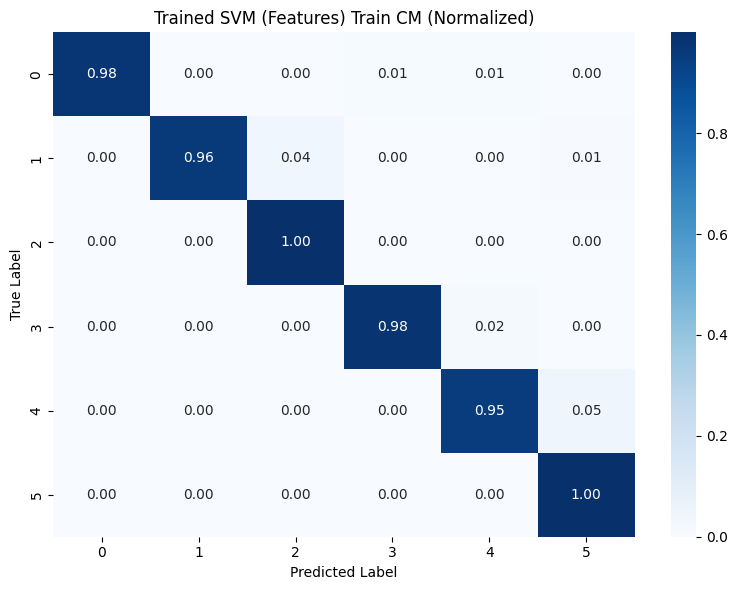

Saved confusion matrix plot to: /kaggle/working/svm_val_cm.png


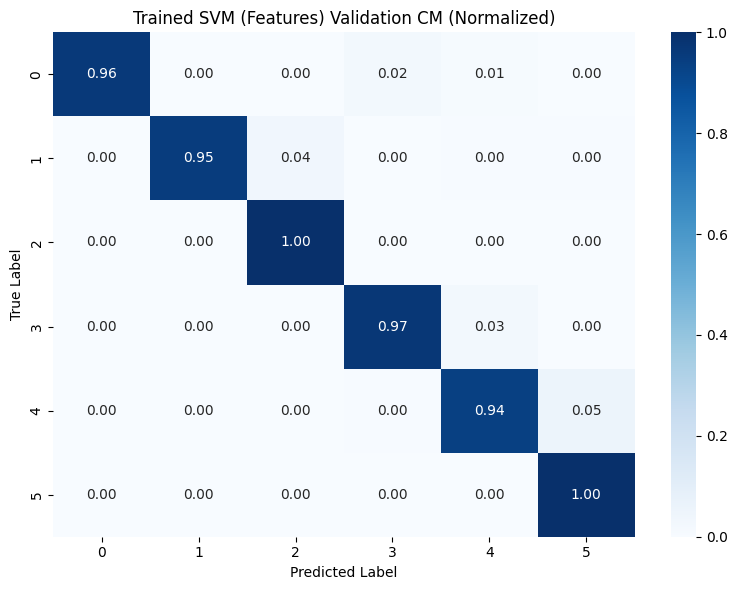

Saved confusion matrix plot to: /kaggle/working/svm_test_cm.png


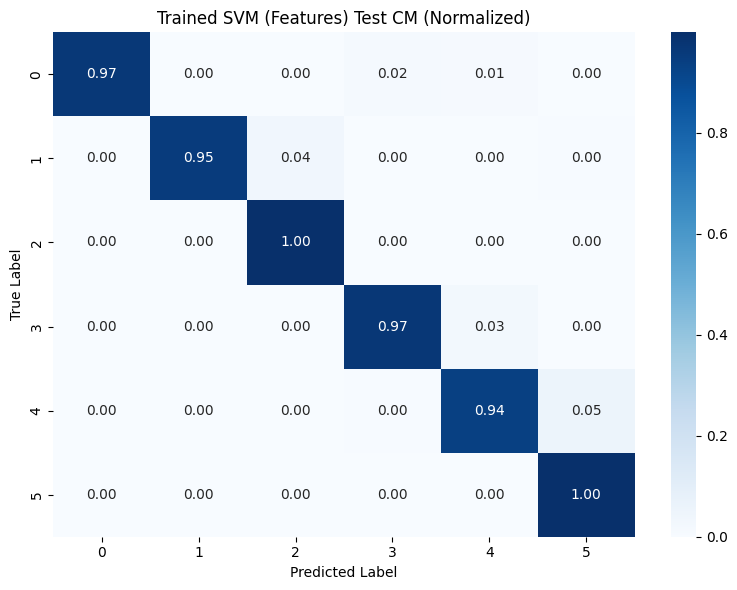


--- Notebook Execution Complete ---


In [16]:

# Confusion Matrix Plotting for SVM
if 'svm_train_preds' in locals() and y_train is not None:
    print("\n--- Generating Confusion Matrices for Trained SVM on Features ---")
    def plot_confusion_matrix(labels, preds, class_names, title, filename="confusion_matrix.png"):
        try:
            cm = confusion_matrix(labels, preds, normalize='true')
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                        xticklabels=class_names, yticklabels=class_names)
            plt.title(title)
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.tight_layout()
            full_filename = os.path.join(CFG.SVM_SAVE_DIR, filename)
            plt.savefig(full_filename)
            print(f"Saved confusion matrix plot to: {full_filename}")
            plt.show()
        except Exception as e:
            print(f"Error plotting confusion matrix '{title}': {e}")

    plot_confusion_matrix(y_train, svm_train_preds, CLASS_NAMES,
                          'Trained SVM (Features) Train CM (Normalized)',
                          filename="svm_train_cm.png")
    plot_confusion_matrix(y_val, svm_val_preds, CLASS_NAMES,
                          'Trained SVM (Features) Validation CM (Normalized)',
                          filename="svm_val_cm.png")
    plot_confusion_matrix(y_test, svm_test_preds, CLASS_NAMES,
                          'Trained SVM (Features) Test CM (Normalized)',
                          filename="svm_test_cm.png")
else:
    print("\nSkipping Confusion Matrix plotting as SVM model or labels are not available.")

print("\n--- Notebook Execution Complete ---")